In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_excel("assets/datasets/dummy_test_data_for_interview.xlsx")


In [3]:
df['row_index'] = df.index

In [4]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [5]:
df = df.drop('peat_id', axis=1)
numeric_cols.remove('peat_id')

In [6]:
df = df.replace(0, np.nan)

In [7]:
df.columns

Index(['date', 'state', 'district', 'subdistrict', 'crop',
       'Leaf wetness probability_mean', 'Precipitation Total_mean',
       'Relative Humidity_max', 'Relative Humidity_min', 'Soil Moisture_mean',
       'Soil Temperature_mean', 'Sunshine Duration_mean', 'Temperature_max',
       'Temperature_min', 'disease_name', 'row_index'],
      dtype='object')

In [8]:
#Filling missing values based on Relative Humidity_min

def replace_with_group_mean(row, Null_column, Reference_column, group_means):
    if pd.isna(row[Null_column]) or row[Null_column] == 0:
        rh_rounded = round(row[Reference_column])
        return group_means.get(rh_rounded, np.nan)
    return row[Null_column]

humidity_group_means_leaf = (
    df[~df['Leaf wetness probability_mean'].isna()]
    .groupby(df['Relative Humidity_min'].round().astype(int))['Leaf wetness probability_mean']
    .mean()
)

df['Leaf wetness probability_mean_filled'] = df.apply(replace_with_group_mean, axis=1, 
                                                      Null_column='Leaf wetness probability_mean',
                                                      Reference_column='Relative Humidity_min',
                                                      group_means=humidity_group_means_leaf)


humidity_group_means_precip = (
    df[~df['Precipitation Total_mean'].isna()]
    .groupby(df['Relative Humidity_min'].round().astype(int))['Precipitation Total_mean']
    .mean()
)

df['Precipitation Total_mean_filled'] = df.apply(replace_with_group_mean, axis=1,
                                                      Null_column='Precipitation Total_mean',
                                                      Reference_column='Relative Humidity_min',
                                                      group_means=humidity_group_means_precip)

In [9]:
df['Leaf wetness probability_mean_filled'].isna().sum()
#df['Precipitation Total_mean_filled'].isna().sum()

13

In [10]:
df['Leaf wetness probability_mean_filled'].median()
#df['Precipitation Total_mean_filled'].median()

26.42692727452566

In [11]:
#filling remaining missing values - mean of the column
df['Leaf wetness probability_mean_filled'] = df['Leaf wetness probability_mean_filled'].fillna(df['Leaf wetness probability_mean_filled'].median())
#df['Precipitation Total_mean_filled'] = df['Precipitation Total_mean_filled'].fillna(df['Precipitation Total_mean_filled'].median())

In [12]:
df.isna().sum()
#(df== 0).sum()

date                                       0
state                                      0
district                                   0
subdistrict                                0
crop                                       0
Leaf wetness probability_mean           4194
Precipitation Total_mean                3460
Relative Humidity_max                      0
Relative Humidity_min                      0
Soil Moisture_mean                         0
Soil Temperature_mean                      0
Sunshine Duration_mean                     0
Temperature_max                            0
Temperature_min                            0
disease_name                               0
row_index                                  1
Leaf wetness probability_mean_filled       0
Precipitation Total_mean_filled           13
dtype: int64

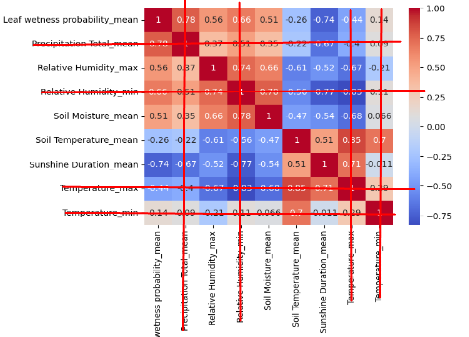

In [13]:
#cols=['Leaf wetness probability_mean_filled','Precipitation Total_mean_filled','Relative Humidity_max', 'Relative Humidity_min','Soil Moisture_mean', 'Soil Temperature_mean', 'Temperature_min','Sunshine Duration_mean']

In [14]:
cols=['Leaf wetness probability_mean_filled','Relative Humidity_max', 'Soil Moisture_mean', 'Soil Temperature_mean', 'Sunshine Duration_mean']

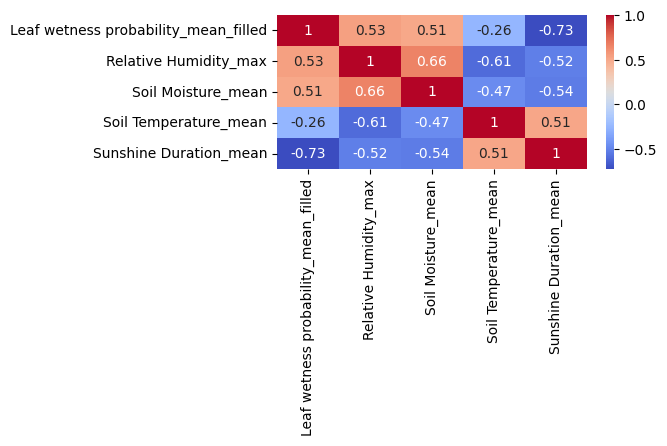

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 2))
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm')
plt.show()

In [16]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

In [17]:
for col in categorical_cols:
    print(f" {col}: {df[col].nunique()}")

 state: 2
 district: 69
 subdistrict: 909
 crop: 3
 disease_name: 10


In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le_target = LabelEncoder()
le_state = LabelEncoder()
le_crop = LabelEncoder()

df['target'] = le_target.fit_transform(df['disease_name'])
df['state'] = le_state.fit_transform(df['state'])
df['crop'] = le_crop.fit_transform(df['crop'])


In [19]:
import category_encoders as ce

target_enc = ce.TargetEncoder(cols=['district', 'subdistrict'])
df[['district', 'subdistrict']] = target_enc.fit_transform(df[['district', 'subdistrict']], df['target'])




#target_enc2 = ce.TargetEncoder(cols=['crop'])
#df['crop'] = target_enc2.fit_transform(df['crop'], df['target'])


In [20]:
#df = pd.get_dummies(df, columns=['state', 'crop'], drop_first=False)

In [21]:
features = ['Leaf wetness probability_mean_filled','Relative Humidity_max', 
            'Soil Moisture_mean', 'Soil Temperature_mean', 'Sunshine Duration_mean',
            'state','district', 'subdistrict', 'crop', 
            'month']

In [22]:
New_df = df[['row_index']+features + ['target']].copy()

In [23]:
New_df.dropna(inplace=True)

In [24]:
New_df.to_csv("assets/datasets/processed_data_noSClaing.csv", index=False)

In [25]:
New_df.head()

,row_index,Leaf wetness probability_mean_filled,Relative Humidity_max,Soil Moisture_mean,Soil Temperature_mean,Sunshine Duration_mean,state,district,subdistrict,crop,month,target
1,1.0,17.385738,72.739670,0.286917,31.440296,30.091097,0,4.541209,4.381941,1,6,1
2,2.0,0.374650,65.237881,0.241905,34.594764,26.626924,0,4.989712,5.044468,1,6,1
3,3.0,0.163749,61.508752,0.266179,35.209524,26.622719,0,5.658982,4.849062,1,6,2
4,4.0,5.230859,88.774765,0.158804,32.471370,26.069087,0,3.941714,3.810433,2,6,0
5,5.0,8.507470,60.066203,0.128673,37.879463,24.273178,0,3.818605,3.361557,2,6,0


In [26]:

import joblib

preprocessor = {
    'leaf_wetness_probability_mean_median': 26.43,
    'label_encoder_state': le_state,
    'label_encoder_crop': le_crop,
    'label_encoder_target': le_target,
    'target_encoder': target_enc,
    'features': features

}

joblib.dump(preprocessor, 'assets/models/preprocessor.pkl')


['assets/models/preprocessor.pkl']